In [3]:
import fastbook
fastbook.setup_book()
from fastbook import *

In [4]:
from fastai.collab import *
from fastai.tabular.all import *

# Building and fitting the model

In [5]:
path = untar_data(url = 'https://files.grouplens.org/datasets/movielens/ml-25m.zip', fname = 'ml-25m')

In [6]:
path.ls()

(#7) [Path('/storage/data/ml-25m/ratings.csv'),Path('/storage/data/ml-25m/tags.csv'),Path('/storage/data/ml-25m/links.csv'),Path('/storage/data/ml-25m/README.txt'),Path('/storage/data/ml-25m/movies.csv'),Path('/storage/data/ml-25m/genome-tags.csv'),Path('/storage/data/ml-25m/genome-scores.csv')]

In [7]:
readme = path/'README.txt'

In [8]:
readme.readlines()

['Summary\n',
 '=======\n',
 '\n',
 'This dataset (ml-25m) describes 5-star rating and free-text tagging activity from [MovieLens](http://movielens.org), a movie recommendation service. It contains 25000095 ratings and 1093360 tag applications across 62423 movies. These data were created by 162541 users between January 09, 1995 and November 21, 2019. This dataset was generated on November 21, 2019.\n',
 '\n',
 'Users were selected at random for inclusion. All selected users had rated at least 20 movies. No demographic information is included. Each user is represented by an id, and no other information is provided.\n',
 '\n',
 'The data are contained in the files `genome-scores.csv`, `genome-tags.csv`, `links.csv`, `movies.csv`, `ratings.csv` and `tags.csv`. More details about the contents and use of all these files follows.\n',
 '\n',
 'This and other GroupLens data sets are publicly available for download at <http://grouplens.org/datasets/>.\n',
 '\n',
 '\n',
 'Usage License\n',
 '===

In [9]:
# Create the ratings dataframe
ratings = pd.read_csv(path/'ratings.csv', delimiter=',', header=[0])
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [10]:
# Create the movies dataframe
movies = pd.read_csv(path/'movies.csv', delimiter=',', header=[0])
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [11]:
# Merge the two dataframes
ratings = ratings.merge(movies, on = 'movieId')

In [12]:
ratings.head(10)

,userId,movieId,rating,timestamp,title,genres
0,1,296,5.0,1147880044,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
1,3,296,5.0,1439474476,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
2,4,296,4.0,1573938898,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
3,5,296,4.0,830786155,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
4,7,296,4.0,835444730,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
5,8,296,5.0,890489713,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
6,10,296,4.5,1227571308,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
7,12,296,5.0,1119354604,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
8,13,296,5.0,1238029599,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
9,14,296,5.0,1506208897,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller


In [17]:
# Create the dataloaders
dls = CollabDataLoaders.from_df(ratings, user_name = 'userId', item_name = 'title', rating_name = 'rating', 
                                bs = 64)

In [18]:
dls.show_batch()

,userId,title,rating
0,149775,Sleeping Giant (2015),3.0
1,128814,Austin Powers in Goldmember (2002),3.0
2,146281,The Happiest Day in the Life of Olli Mäki (2016),4.5
3,143864,Halloween 5: The Revenge of Michael Myers (1989),3.0
4,65471,Heat (1995),5.0
5,142111,Star Wars: Episode VI - Return of the Jedi (1983),4.5
6,132548,50/50 (2011),3.0
7,58679,Mulan (1998),3.5
8,106358,Heartbreak Ridge (1986),4.0
9,139560,The Butterfly Effect (2004),5.0


In [19]:
learn = collab_learner(dls, n_factors=50, y_range=(0,5.5))

In [20]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.954976,1.005482,53:52
1,1.008398,1.004600,53:46
2,0.965274,0.976236,53:44
3,0.961582,0.928273,53:44
4,0.881228,0.894774,53:43


# Interpreting the results

In [24]:
# Analyze the results using the 1000 most rated movies
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Forrest Gump (1994)', 'Shawshank Redemption, The (1994)', 'Pulp Fiction (1994)', 'Silence of the Lambs, The (1991)', 'Matrix, The (1999)', 'Star Wars: Episode IV - A New Hope (1977)',
       'Jurassic Park (1993)', "Schindler's List (1993)", 'Braveheart (1995)', 'Fight Club (1999)'], dtype=object)

In [25]:
# Pull the bias of each movie to find the 'value' of each movie
movie_bias = learn.model.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [28]:
# Compare the biases with the average ratings
mean_ratings = ratings.groupby('title')['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(
    top_movies, movie_bias)]

In [29]:
# Analyze the movies with the worst bias
item0 = lambda o:o[0]
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.2502), 'Batman & Robin (1997)', 2.160149918962723),
 (tensor(-0.2207), 'Wild Wild West (1999)', 2.31967073274759),
 (tensor(-0.2018), 'Showgirls (1995)', 2.2478297395687483),
 (tensor(-0.1736), 'Godzilla (1998)', 2.373144567793439),
 (tensor(-0.1669), 'Flintstones, The (1994)', 2.4127870563674323),
 (tensor(-0.1442), 'Scream 3 (2000)', 2.430953105968331),
 (tensor(-0.1422), 'Striptease (1996)', 2.403895524054024),
 (tensor(-0.1268),
  'I Know What You Did Last Summer (1997)',
  2.4885263297519566),
 (tensor(-0.1104), 'Hollow Man (2000)', 2.53809586689555),
 (tensor(-0.1102), 'Daredevil (2003)', 2.5169466106778646),
 (tensor(-0.1088), 'Coneheads (1993)', 2.5814764286797027),
 (tensor(-0.1071),
  'Ace Ventura: When Nature Calls (1995)',
  2.6421677802524126),
 (tensor(-0.1047), 'Judge Dredd (1995)', 2.555359804851606),
 (tensor(-0.1027), 'Honey, I Shrunk the Kids (1989)', 2.718742232165051),
 (tensor(-0.0903), 'Lost in Space (1998)', 2.5775415644589805)]

In [32]:
# Analyze the movies with the best bias
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(1.0189), 'Shawshank Redemption, The (1994)', 4.413576004516335),
 (tensor(0.8634), 'Usual Suspects, The (1995)', 4.284353213163313),
 (tensor(0.8501), 'Godfather, The (1972)', 4.324336165187245),
 (tensor(0.8345), "Schindler's List (1993)", 4.247579083279535),
 (tensor(0.8068), 'Fight Club (1999)', 4.228310618821568),
 (tensor(0.7974), 'Silence of the Lambs, The (1991)', 4.151341616415071),
 (tensor(0.7794), 'Pulp Fiction (1994)', 4.188912039361382),
 (tensor(0.7578), 'Matrix, The (1999)', 4.154099127610975),
 (tensor(0.7481), 'Godfather: Part II, The (1974)', 4.2617585117585115),
 (tensor(0.7322),
  "One Flew Over the Cuckoo's Nest (1975)",
  4.2186616007543405),
 (tensor(0.7316), 'Dark Knight, The (2008)', 4.166538211421277),
 (tensor(0.7309),
  'Star Wars: Episode IV - A New Hope (1977)',
  4.120188599618726),
 (tensor(0.7297), 'Inception (2010)', 4.155508420105412),
 (tensor(0.7297), 'Forrest Gump (1994)', 4.048011436845787),
 (tensor(0.7052), 'Memento (2000)', 4.149957519

## Analyze the learned latent factors

In [33]:
# Grab the weights for each movie in top_movies
movie_w = learn.model.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 50])

In [34]:
# Use a PCA to reduce the dimensions
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [35]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [36]:
# Highest scores on the first dimension
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(2.0241), 'Godfather, The (1972)'),
 (tensor(2.0184),
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)'),
 (tensor(1.9945), 'Pulp Fiction (1994)'),
 (tensor(1.9480), 'Citizen Kane (1941)'),
 (tensor(1.9011), 'Casablanca (1942)'),
 (tensor(1.8510), 'Fargo (1996)'),
 (tensor(1.8296), 'Apocalypse Now (1979)'),
 (tensor(1.8024), "One Flew Over the Cuckoo's Nest (1975)"),
 (tensor(1.7925), 'Seven Samurai (Shichinin no samurai) (1954)'),
 (tensor(1.7653), 'Godfather: Part II, The (1974)')]

In [37]:
# Worst scores on the first dimension
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.9987), 'Independence Day (a.k.a. ID4) (1996)'),
 (tensor(-1.9208), 'Net, The (1995)'),
 (tensor(-1.8854), 'Batman & Robin (1997)'),
 (tensor(-1.8441), 'Twister (1996)'),
 (tensor(-1.7815), 'Wild Wild West (1999)'),
 (tensor(-1.7648), 'Batman Forever (1995)'),
 (tensor(-1.7144), 'Armageddon (1998)'),
 (tensor(-1.7001), 'Congo (1995)'),
 (tensor(-1.6714), 'Judge Dredd (1995)'),
 (tensor(-1.5842), 'Broken Arrow (1996)')]

In [38]:
# Highest scores on the second dimension
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.3557), 'Showgirls (1995)'),
 (tensor(1.0483), 'Striptease (1996)'),
 (tensor(1.0077), 'Tank Girl (1995)'),
 (tensor(0.9997), 'Batman & Robin (1997)'),
 (tensor(0.9424), 'Thin Red Line, The (1998)'),
 (tensor(0.9393), 'Brady Bunch Movie, The (1995)'),
 (tensor(0.9297), 'Escape from L.A. (1996)'),
 (tensor(0.8972), 'Mission to Mars (2000)'),
 (tensor(0.8573), 'Blair Witch Project, The (1999)'),
 (tensor(0.8463), 'Eyes Wide Shut (1999)')]

In [39]:
# Lowest scores on the second dimension
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.3281), 'Lord of the Rings: The Return of the King, The (2003)'),
 (tensor(-1.3026), 'Shawshank Redemption, The (1994)'),
 (tensor(-1.2640), 'Inception (2010)'),
 (tensor(-1.2449), 'Lord of the Rings: The Two Towers, The (2002)'),
 (tensor(-1.2016), 'Dark Knight, The (2008)'),
 (tensor(-1.1732),
  'Lord of the Rings: The Fellowship of the Ring, The (2001)'),
 (tensor(-1.1615), 'Gladiator (2000)'),
 (tensor(-1.1526), 'Forrest Gump (1994)'),
 (tensor(-1.1252), 'Matrix, The (1999)'),
 (tensor(-1.1222), 'Dark Knight Rises, The (2012)')]

## Plot the movies according to their scores on the dimensions

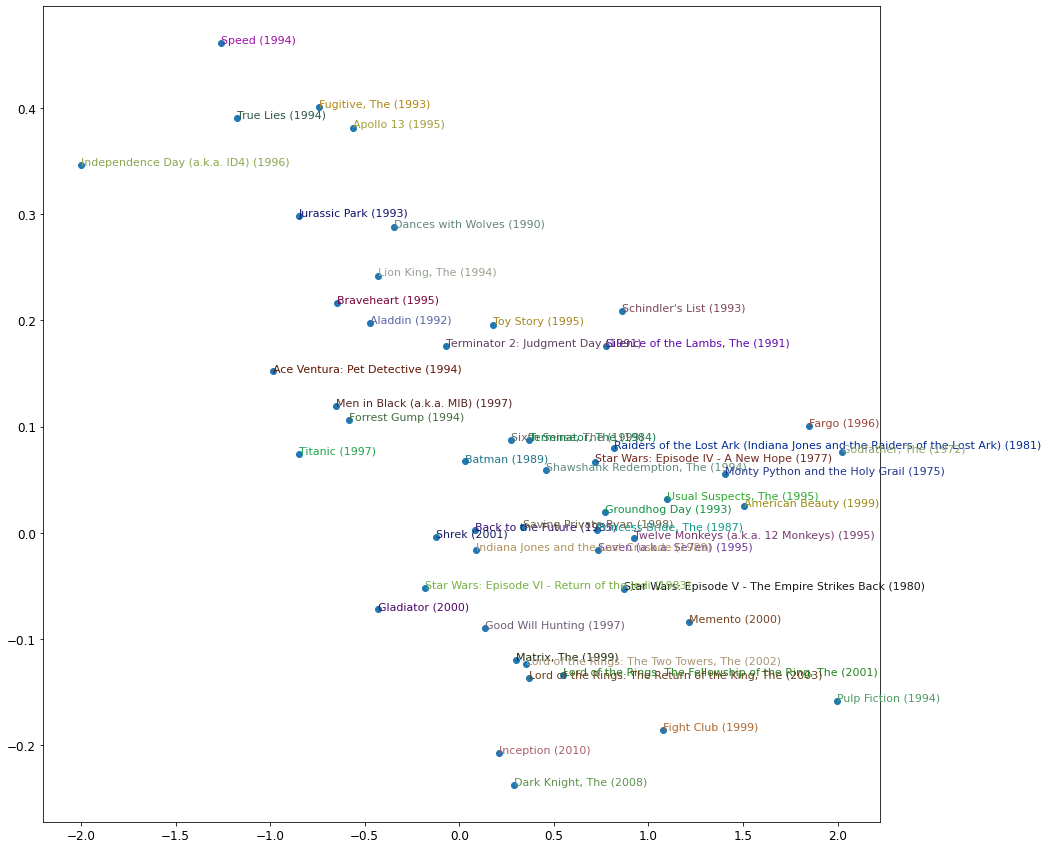

In [41]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()